In [3]:
import numpy as np
import gizmo_analysis as gizmo
import utilities as ut
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import clear_output
from matplotlib.patches import Ellipse
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
import matplotlib.cm as cm
import pickle

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from astropy.io import ascii

from scipy import optimize, stats
import emcee
import corner

plt.rcParams["font.family"] = "Serif"
plt.rcParams.update({'font.size': 10, 'font.weight' : 100})

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
# Dictionary with galaxy name and corresponding local directory containing the HDF5 - for ease of access. 

dirs = { 'm11b' : 'D:\Data\m11b_res260' , 'm11q' : 'D:\Data\m11q_res880', 
       'm11h' : 'D:\Data\m11h_res880', 'm10v' : 'D:\Data\m10v_res250',
       'm11d' : 'D:\Data\m11d_res7100', 'm12i' : 'D:\Data\m12i_res7100',
       'm12i_low_res' : 'D:\Data\m12i_res57000', 'm11e' : 'D:\Data\m11e_res7100',
       'm11i' : 'D:\Data\m11i_res7100', 'm10q' : 'D:\Data\m10q_res250'}


# Function below loads the snapshot 600 from the directory that it has been assigned to. Simply use the galaxy's name
# in lowercase to get your data.

# "Load" can be found in Rformation for m1Xx

def load_with_formation():
    galaxy = 'm10q'
    
    print('LOADING GALAXY: ' + galaxy + " in " + dirs[galaxy])
    
    part = gizmo.io.Read.read_snapshots(['star', 'gas', 'dark'], 'redshift', 0, assign_hosts = 'mass', assign_hosts_rotation = True, 
                                        simulation_name=str(galaxy), simulation_directory=dirs[galaxy],
                                            assign_formation_coordinates = True)
    
    species='star'
    mass = part[species].prop('mass')
    age = part[species].prop('age')
    feh  = part[species].prop('metallicity.fe')
    sife = part[species].prop('metallicity.si - metallicity.fe')
    cafe = part[species].prop('metallicity.ca - metallicity.fe') 
    ofe = part[species].prop('metallicity.o - metallicity.fe') 
    
    Rxy = part[species].prop('host.distance.principal.cylindrical')[:,0]
    z = part[species].prop('host.distance.principal.cylindrical')[:,1]
    mgfe = part[species].prop('metallicity.mg - metallicity.fe')
    
    x = part[species].prop('host.distance.principal')[:,0]
    y = part[species].prop('host.distance.principal')[:,1]
    z = part[species].prop('host.distance.principal')[:,2]
    
    R = part[species].prop('host.distance.principal.cylindrical')[:,0]
    form = part[species].prop('form.host.distance.principal.cylindrical')

    return part, galaxy, mass, age, feh, sife, cafe, ofe, Rxy, z, mgfe, x, y, z, R, form

In [7]:
part, galaxy, mass, age, feh, sife, cafe, ofe, Rxy, z, mgfe, x, y, z, R, form = load_with_formation()
#part, galaxy, mass, age, feh, sife, cafe, ofe, Rxy, z, mgfe, x, y, z, R, phi = load()
clear_output()
Rform = form[:,0]
print("Loaded m10q!")

Loaded m10q!


In [8]:
colors = ['black', 'red', 'blue', 'green']
ranges = [0,1,2,3]
inds = []
indices, sf, redshift, time, twidth = np.loadtxt("snapshot_times.txt", unpack = True, skiprows = 3)

for i in range(0, len(ranges)-1):

    inds.append(np.where( ( R >= ranges[i] ) & ( R <= ranges[i+1] ) ) )

In [9]:
print(len(form[np.where( (R < 30) & (Rform > 30))]))
print("EX SITU (10 KPC)")
print(100*len(form[np.where((R < 10) & (Rform > 10))])/len(form))
print("EX SITU (30 KPC)")
print(100*len(form[np.where((R < 10) & (Rform > 30))])/len(form))

17
EX SITU (10 KPC)
3.120057512580877
EX SITU (30 KPC)
0.12221423436376708


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


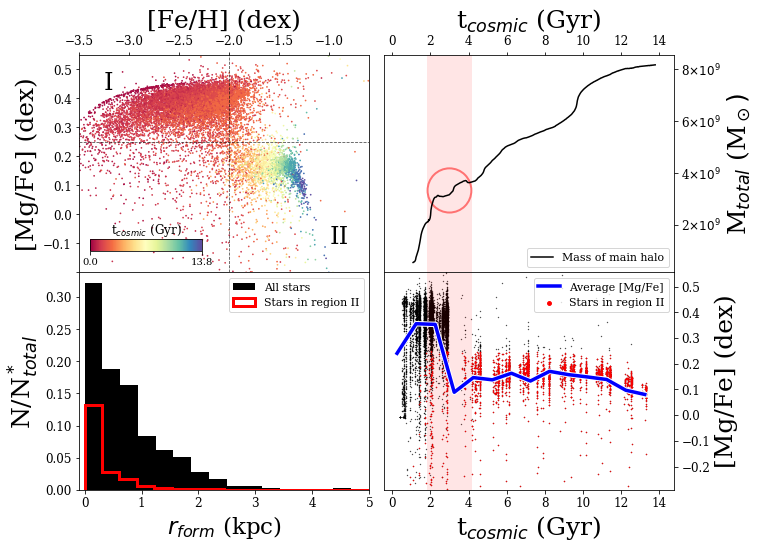

In [12]:
fig = plt.figure(figsize = (10.67,8), frameon = False)

tform = 13.7987-age

file_a = 'galaxies/m10q/main_mass'
main_m = open(file_a,'rb')
main_mass = pickle.load(main_m, encoding = 'latin1')

sec_ind = np.where( (mgfe <= 0.25) & (feh >= -2))

colors = ['black', 'red', 'blue', 'green']
ranges = [0,1,2,3]


ax1 = fig.add_subplot(2, 2, 1)

############# THE FOLLOWING CODE IS FOR GENERATING AN INSET COLORBAR ############

ind = np.where(Rform < 100)
counts1,xbins1,ybins1,image1 = plt.hist2d(feh[ind], mgfe[ind], bins = [100,100])

#mean age for bins of stars in mgfe vs feh space
mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(feh[ind], mgfe[ind], 
                                                                    age[ind], 'mean', bins= [100,100])

#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_age1)
im = ax1.imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = 'Spectral', aspect='auto', vmin=0, vmax=13.8)
ax1.clear()

cbar_ax = fig.add_axes([ 0.14, 0.54, 0.145, 0.02]) #left, bottom, width, height  # vertically oriented colorbar

cb = fig.colorbar(im, cax=cbar_ax, ticks = [0,13.8],  orientation = 'horizontal')
#cb.ax.yaxis.set_ticks_position("right")
#cb.ax.set_yticklabels(['0 Gyr', '13.8 Gyr'], fontweight = 15) # Used to make custom labels on the tick marks themselves
cb.ax.set_title(r"t$_{cosmic}$ (Gyr)")
#cb.ax.yaxis.set_label_position("left")

############# THE ABOVE CODE IS FOR GENERATING AN INSET COLORBAR ############

#ax1.scatter(feh,mgfe-0.0005, s = 0.5, alpha = 0.5, c = 'black')
ax1.scatter(feh,mgfe, s = 0.5, c = tform, cmap = "Spectral")
ax1.set_ylim(-0.2, 0.55)
ax1.axvline(-2, ls = "--", color = 'black', lw = 0.8, alpha = 0.7)
ax1.axhline(0.25, ls = "--", color = 'black', lw = 0.8, alpha = 0.7)

ax1.set_ylabel("[Mg/Fe] (dex)", size = 25)
ax1.set_xlabel("[Fe/H] (dex)", size = 25, labelpad = 7)
ax1.xaxis.set_label_position("top")
ax1.xaxis.tick_top()
ax1.set_xlim(-3.5,-0.6)

ax1.text(-3.25,0.43, "I", size = 24)
ax1.text(-1,-0.1, "II", size = 24)

xticks1 = ax1.xaxis.get_majorticklabels()
yticks1 = ax1.yaxis.get_majorticklabels()
plt.setp(yticks1[0], visible = False)


ax2 = fig.add_subplot(2, 2, 2)

ax2.axvline(3, lw = 45, color = 'r', alpha = 0.1)
ax2.ticklabel_format(useOffset=False, style = 'plain')
ax2.yaxis.set_ticks([2e9,4e9,6e9,8e9])
ax2.yaxis.set_ticklabels([r'2$\times 10^{9}$',r'4$\times 10^{9}$',r'6$\times 10^{9}$',r'8$\times 10^{9}$'])
ax2.plot(time[60:600], main_mass, color = 'black', label = "Mass of main halo")
ell = matplotlib.patches.Ellipse(xy=[3, main_mass[160]-0.5e9], width=2.3, height= 0.17e10, angle = 0, color = 'red', 
                                 fill = False, alpha = 0.5, lw = 2, label = "Mass accreted from second halo")
ax2.add_artist(ell)

ax2.set_xlabel(r"t$_{cosmic}$ (Gyr)", size = 25, labelpad = 7)
ax2.xaxis.set_label_position("top")
ax2.xaxis.tick_top()
ax2.legend(fontsize = 11)
ax2.set_ylabel(r"M$_{total}$ (M$_\odot)$", size = 25)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

xticks2 = ax2.xaxis.get_majorticklabels()
yticks2 = ax2.yaxis.get_majorticklabels()

weights1 = np.ones_like(Rform)/float(len(Rform))
weights2 = np.ones_like(Rform[sec_ind])/float(len(Rform))


ax3 = fig.add_subplot(2, 2, 3)
ax3.hist(Rform, bins = 470, color = 'black', label = "All stars", weights = weights1)
ax3.hist(Rform[sec_ind], bins = 47, color = 'red', histtype = 'step', weights = weights2,
         lw = 3, label = "Stars in region II")
ax3.legend(fontsize = 11)
ax3.set_ylabel(r"N/N$^*_{total}$", size = 25)
ax3.yaxis.set_label_position("left")
ax3.set_xlim(-0.1,5)

xticks3 = ax3.xaxis.get_majorticklabels()
yticks3 = ax3.yaxis.get_majorticklabels()

ax3.set_xlabel(r"$r_{form}$ (kpc)", size = 23)


tform = 13.7987 - age

#agers = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5]
agers = [0.25,1.25,2.25,3.25,4.25,5.25,6.25,7.25,8.25,9.25,10.25,11.25,12.25,13.25,14.25]

means = []

for i in range(0, len(agers)-1):
    ind = np.where((tform > agers[i]) & (tform < agers[i+1]))
    means.append(np.mean(mgfe[ind]))

means = np.array(means)
agers = np.array(agers)

ax4 = fig.add_subplot(2, 2, 4, sharex = ax2)
ax4.yaxis.tick_right()
#ax4.axvline(3, lw = 8, color = 'b', alpha = 0.5)
ax4.axvline(3, lw = 45, color = 'r', alpha = 0.1)

ax4.scatter(tform, mgfe, color = 'black', s = 0.1)
ax4.scatter(tform[sec_ind], mgfe[sec_ind], color = 'r', s = 0.2)
#ax4.axhline(np.mean(mgfe), color = 'green', label = "<[Mg/Fe]> = " + str(round(np.mean(mgfe),3)))
ax4.scatter(14,14, color = 'r', s = 15, label = "Stars in region II")
#ax4.plot(agers[0:14], means[0:14]-0.006, color = 'black', lw = 5, alpha = 0.5) 
ax4.plot(agers[0:14], means[0:14], color = 'white', lw = 5.5)    
ax4.plot(agers[0:14], means[0:14], color = 'b', lw = 3.5, label = "Average [Mg/Fe]")    


ax4.yaxis.set_label_position("right")
ax4.set_ylabel("[Mg/Fe] (dex)", size = 25)
ax4.set_ylim(-0.29, np.max(mgfe))

ax4.legend(fontsize = 11)

xticks4 = ax4.xaxis.get_majorticklabels()
yticks4 = ax4.yaxis.get_majorticklabels()
ax4.set_xlabel(r"t$_{cosmic}$ (Gyr)", size = 25)

plt.setp([xticks1,xticks2,xticks3,xticks4, yticks1, yticks2, yticks3, yticks4], size = 12)

plt.subplots_adjust(wspace=.05, hspace=.0)

#plt.figtext(0.505, .93, "m10q", ha = "center", size = 25) # MUCH better alternative to plt.text().

plt.savefig("m10q_master.png", dpi = 150)

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


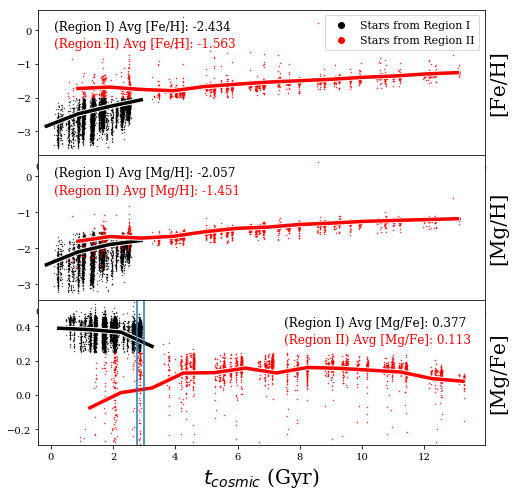

In [8]:
thr_ind = np.where( (mgfe >= 0.25) & (mgfe <= 0.6) & (feh >= -3.5) & (feh <= -2))

fig = plt.figure(figsize = (8,8), frameon = False)
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

mg = part['star'].prop("metallicity.mg")

ax1.scatter(tform[thr_ind], feh[thr_ind], color = 'black', s = 0.1)
#ax1.axhline(np.average(feh[thr_ind]), color = 'black')

ax1.scatter(tform[sec_ind], feh[sec_ind], color = 'r', s = 0.2)
ax1.set_ylabel("[Fe/H]", size = 20)
ax1.yaxis.set_label_position("right")
ax1.scatter(-3,-3, color = 'black', label = "Stars from Region I")
ax1.scatter(-3,-3, color = 'r', label = "Stars from Region II")
ax1.set_xlim(0,)
ax1.legend(fontsize = 11, loc = 1)

ax2.scatter(tform[thr_ind], mg[thr_ind], color = 'black', label = "Stars from Region I", s = 0.1)
ax2.scatter(tform[sec_ind], mg[sec_ind], color = 'r', s = 0.2)
ax2.scatter(-3,-3, color = 'r', label = "Stars from Region II")
ax2.set_xlim(0,)
ax2.set_ylabel("[Mg/H]", size = 20)
ax2.yaxis.set_label_position("right")

ax3.scatter(tform[thr_ind], mgfe[thr_ind], color = 'black', s = 0.1)
ax3.scatter(tform[sec_ind], mgfe[sec_ind], color = 'r', s = 0.2)
ax3.set_ylabel("[Mg/Fe]", size = 20)
ax3.set_ylim(-0.29, np.max(mgfe))
ax3.yaxis.set_label_position("right")

tform = 13.7987 - age

#agers = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5]
agers = [0.25,1.25,2.25,3.25,4.25,5.25,6.25,7.25,8.25,9.25,10.25,11.25,12.25,13.25,14.25]

means_fe1 = []
means_fe2 = []
means_mg1 = [] 
means_mg2 = [] 
means_mgf1 = []
means_mgf2 = []

for i in range(0, len(agers)-1):
    ind1 = np.where((tform[thr_ind] > agers[i]) & (tform[thr_ind] < agers[i+1]))
    ind2 = np.where((tform[sec_ind] > agers[i]) & (tform[sec_ind] < agers[i+1]))
    means_fe1.append(np.mean(feh[thr_ind][ind1]))
    means_fe2.append(np.mean(feh[sec_ind][ind2])) 
    means_mg1.append(np.mean(mg[thr_ind][ind1])) 
    means_mg2.append(np.mean(mg[sec_ind][ind2])) 
    means_mgf1.append(np.mean(mgfe[thr_ind][ind1]))
    means_mgf2.append(np.mean(mgfe[sec_ind][ind2]))

means_fe1 = np.array(means_fe1)
means_fe2 = np.array(means_fe2)
means_mg1 = np.array(means_mg1)
means_mg2 = np.array(means_mg2)
means_mgf1 = np.array(means_mgf1)
means_mgf2 = np.array(means_mgf2)

avgs1 = (np.average(feh[thr_ind]))
avgs2 = (np.average(feh[sec_ind]))
avgs3 = (np.average(mg[thr_ind]))
avgs4 = (np.average(mg[sec_ind]))
avgs5 = (np.average(mgfe[thr_ind]))
avgs6 = (np.average(mgfe[sec_ind]))

agers = np.array(agers)

ax1.plot(agers[0:4], means_fe1[0:4], color = 'white', lw = 5.5)    
ax1.plot(agers[0:4], means_fe1[0:4], color = 'black', lw = 3.5)  
ax1.plot(agers[1:14], means_fe2[1:14], color = 'white', lw = 5.5)    
ax1.plot(agers[1:14], means_fe2[1:14], color = 'red', lw = 3.5)  
ax1.text(0.5,0, "(Region I) Avg [Fe/H]: " + str(round(avgs1,3)), size = 12)
ax1.text(0.5,-0.5, "(Region II) Avg [Fe/H]: " + str(round(avgs2,3)), color = 'red', size = 12)


ax2.plot(agers[0:4], means_mg1[0:4], color = 'white', lw = 5.5)    
ax2.plot(agers[0:4], means_mg1[0:4], color = 'black', lw = 3.5)  
ax2.plot(agers[1:14], means_mg2[1:14], color = 'white', lw = 5.5)    
ax2.plot(agers[1:14], means_mg2[1:14], color = 'red', lw = 3.5)  
ax2.text(0.5,0, "(Region I) Avg [Mg/H]: " + str(round(avgs3,3)), size = 12)
ax2.text(0.5,-0.5, "(Region II) Avg [Mg/H]: " + str(round(avgs4,3)), color = 'red', size = 12)

ax3.plot(agers[0:4], means_mgf1[0:4], color = 'white', lw = 5.5)    
ax3.plot(agers[0:4], means_mgf1[0:4], color = 'black', lw = 3.5)  
ax3.plot(agers[1:14], means_mgf2[1:14], color = 'white', lw = 5.5)    
ax3.plot(agers[1:14], means_mgf2[1:14], color = 'red', lw = 3.5)
ax3.text(7.5,0.4, "(Region I) Avg [Mg/Fe]: " + str(round(avgs5,3)), size = 12)
ax3.text(7.5,0.3, "(Region II) Avg [Mg/Fe]: " + str(round(avgs6,3)), color = 'red', size = 12)

ax3.axvline(3)
ax3.axvline(2.76)

plt.subplots_adjust(wspace=.05, hspace=.0)

plt.xlabel(r"$t_{cosmic}$ (Gyr)", size=20)

plt.savefig("Metallicity_m10q.png", bbox_inches = 'tight', dpi = 100)
plt.show()



In [9]:
fr_ind = np.where( (mgfe >= 0.25) & (mgfe <= 0.6) & (feh >= -3.5) & (feh <= -2) & (tform <= 3))
fr_ind2 = np.where( (mgfe >= 0.25) & (mgfe <= 0.6) & (feh >= -3.5) & (feh <= -2) & (tform > 3))

sec_ind2 = np.where( (mgfe <= 0.25) & (feh >= -2) & (tform <= 3))
sec_ind22 = np.where( (mgfe <= 0.25) & (feh >= -2) & (tform > 3))

ind3 = np.where((mgfe >= 0.25) & (mgfe <= 0.6) & (feh >= -3.5) & (feh <= -2) & (tform <= 2.95) & (tform >= 2.75))


print("Region 1 stars (total): " + str(len(mg[thr_ind])))
print("Region 1 stars that form before 3 Gyr: " + str(len(mg[fr_ind])))
print("Region 1 stars that form after 3 Gyr: " + str(len(mg[fr_ind2])))
print("Region 1 stars make up " + str(round(100*len(mg[thr_ind])/len(mg),3)) + str(" % of all stars"))
print("-------------------------------------------")
print("Region 2 stars (total): " + str(len(mg[sec_ind])))
print("Region 2 stars that form before 3 Gyr: " + str(len(mg[sec_ind2])))
print("Region 2 stars that form after 3 Gyr: " + str(len(mg[sec_ind22])))
print(str(100*round((308/2639),4)) + "% of region 2 stars form before the break.")
print("Region 2 stars make up " + str(round(100*len(mg[sec_ind])/len(mg),3)) + str(" % of all stars"))

print("-------------------------------------------")
print(str(round( (100.0 - (65.104+18.972)), 3)) + "% of stars are in neither region.")

print(np.max(tform[ind3]))
print(len(tform[ind3]))
print(len(tform[ind3]))

print(np.min(tform[sec_ind22]))

Region 1 stars (total): 9056
Region 1 stars that form before 3 Gyr: 9052
Region 1 stars that form after 3 Gyr: 4
Region 1 stars make up 65.104 % of all stars
-------------------------------------------
Region 2 stars (total): 2639
Region 2 stars that form before 3 Gyr: 308
Region 2 stars that form after 3 Gyr: 2331
11.67% of region 2 stars form before the break.
Region 2 stars make up 18.972 % of all stars
-------------------------------------------
15.924% of stars are in neither region.
2.9305521867794493
2019
2019
3.598942452262923


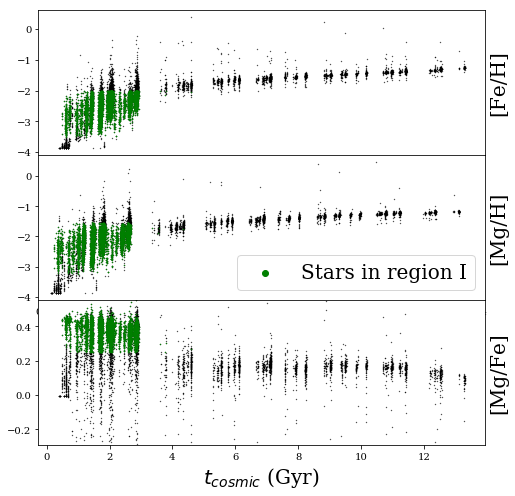

In [8]:
plt.close()
sec_ind = np.where( (mgfe >= 0.25) & (mgfe <= 0.6) & (feh >= -3.5) & (feh <= -2))


fig = plt.figure(figsize = (8,8), frameon = False)
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

mg = part['star'].prop("metallicity.mg")

ax1.scatter(tform, feh, color = 'black', s = 0.1)
ax1.scatter(tform[sec_ind], feh[sec_ind], color = 'g', s = 0.2)
ax1.set_ylabel("[Fe/H]", size = 20)
ax1.yaxis.set_label_position("right")


ax2.scatter(tform, mg, color = 'black', s = 0.1)
ax2.scatter(tform[sec_ind], mg[sec_ind], color = 'g', s = 0.2)
ax2.scatter(-3,-3, color = 'g', label = "Stars in region I")
ax2.set_xlim(0,)
ax2.set_ylabel("[Mg/H]", size = 20)
ax2.yaxis.set_label_position("right")
ax2.legend(fontsize = 20)


ax3.scatter(tform, mgfe, color = 'black', s = 0.1)
ax3.scatter(tform[sec_ind], mgfe[sec_ind], color = 'g', s = 0.2)
ax3.set_ylabel("[Mg/Fe]", size = 20)
ax3.set_ylim(-0.29, np.max(mgfe))
ax3.yaxis.set_label_position("right")



plt.subplots_adjust(wspace=.05, hspace=.0)

plt.xlabel(r"$t_{cosmic}$ (Gyr)", size=20)

plt.savefig("Metallicity_inverse_m10q.png", bbox_inches = 'tight', dpi = 100)
plt.show()

In [28]:
mass_ind = np.where((tform >= 2.7)&(tform <= 3))
mass_prior = np.where(tform < 2.7)
print("Mass produced during burst:  " + str(round(np.sum(mass[mass_ind]),2)/1e5) + "e5 M_sun")
print("Stellar Mass Prior to burst: " + str(round(np.sum(mass[mass_prior]),2)/1e5) + "e5 M_sun")
print((5.23+15.2)/15.2)

Mass produced during burst:  5.23178625e5 M_sun
Stellar Mass Prior to burst: 15.2041725e5 M_sun
1.3440789473684212


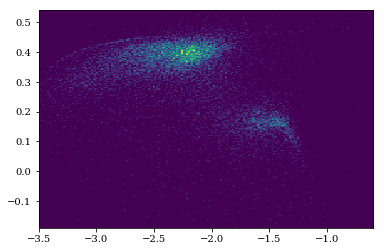

In [9]:
plt.hist2d(feh, mgfe, bins = 200, range = [[-3.5,-0.6],[-.19,.54]])
plt.show()

NameError: name 'b' is not defined

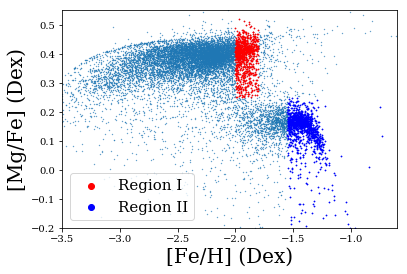

In [10]:
plt.scatter(feh, mgfe, s = 0.1)
plt.ylim(-0.2, 0.55)
plt.xlim(-3.5, -0.6)

ind = np.where( (mgfe > 0.25) & (feh < -1.8) & (feh > -2.)) # Metal rich half Region I
#ind = np.where( (mgfe > 0.25) & (feh < -2)) # Region I
fehi = feh[ind]
mgfei = mgfe[ind]

ind2 = np.where( (mgfe < 0.25) & (feh > -1.55) & (feh > -2.)) # Metal rich half region II
#ind2 = np.where( (mgfe < 0.25) & (feh > -2.))
fehi2 = feh[ind2]
mgfei2 = mgfe[ind2]


plt.scatter(fehi, mgfei, color = 'r', s=  0.5)
plt.scatter(fehi2, mgfei2, color = 'b', s=  0.5)


plt.xlabel("[Fe/H] (Dex)", size = 20)
plt.ylabel("[Mg/Fe] (Dex)", size = 20)

plt.scatter(-9,-9, color = 'r', label = "Region I")
plt.scatter(-9,-9, color = 'b', label = "Region II")

plt.legend(fontsize = 15)

#####################################
def chi2_2(p):
    return np.sum((mgfei-p[0]-p[1]*fehi)**2/(0.01**2 + (p[1]*0.01)**2))

o = optimize.minimize(chi2_2, [b[0],a[0]])
xa = np.linspace(-3.5,0)
print( 'a = %.4f +- %.4f  b = %.4f +- %.4f' % (o.x[0],np.sqrt(o.hess_inv[0,0]),o.x[1],np.sqrt(o.hess_inv[1,1])))
print( 'covariance of a and b = %.5f' % (o.hess_inv[0,1]))
print( 'chi^2 per dof = %.2f' % (chi2_2(o.x)/(len(x)-2)))

plt.plot(xa, o.x[0]+o.x[1]*xa, 'r-')

def chi2_3(p):
    return np.sum((mgfei2-p[0]-p[1]*fehi2)**2/(0.01**2 + (p[1]*0.01)**2))

o = optimize.minimize(chi2_3, [b1[0],a1[0]])
xa = np.linspace(-3.5,0)
print( 'a = %.4f +- %.4f  b = %.4f +- %.4f' % (o.x[0],np.sqrt(o.hess_inv[0,0]),o.x[1],np.sqrt(o.hess_inv[1,1])))
print( 'covariance of a and b = %.5f' % (o.hess_inv[0,1]))
print( 'chi^2 per dof = %.2f' % (chi2_2(o.x)/(len(x)-2)))

plt.plot(xa, o.x[0]+o.x[1]*xa, 'b-')







plt.savefig("m10q_fit4.png", bbox_inches = 'tight', dpi = 100)



plt.show()

In [ ]:
from __future__ import print_function

import emcee
import corner
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator


# Define the probability function as likelihood * prior.
def lnprior(theta):
    m, b, lnf = theta
    if -5 < m < 5 and -10 < b < 10.0 and -10 < lnf < 3.0:
        return 0.0
    return -np.inf

def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b 
    inv_sigma2 = 1.0/(yerr**2 + np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)



m_true=-1
b_true=-.2
c_true=1.0
f_true=.01

def fit_y(x,y,yerr):
    # Find the maximum likelihood value.
    chi2 = lambda *args: -2 * lnlike(*args)
    result = op.minimize(chi2, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
    m_ml, b_ml, lnf_ml = result["x"]
    print(m_ml,b_ml)

    # Set up the sampler. 
    ndim, nwalkers = 3, 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

    # Clear and run the production chain.
    print("Running MCMC...")
    sampler.run_mcmc(pos, 500, rstate0=np.random.get_state())
    print("Done.")

    burnin = 50
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

    # Compute the quantiles.
    samples[:, 2] = np.exp(samples[:, 2])
    m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
    xl=np.array([x.min(),x.max()])
    pl.figure()
    for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
        pl.plot(xl, m*xl+b, color="r", alpha=0.1)
    pl.scatter(x,y)
    pl.show()
    return m_mcmc, b_mcmc, f_mcmc



x0,y0= fehi,mgfei


yerr=0.0005

a,b,d=fit_y(x0,y0,yerr)


print("""MCMC result:
    m = {0}
    b = {1}
    f = {2}
""".format(a, b, d))

x1,y1= fehi2,mgfei2
a1,b1,d1=fit_y(x1,y1,yerr)


print("""MCMC result:
    m = {0}
    b = {1}
    f = {2}
""".format(a1, b1, d1))

In [ ]:
plt.scatter(feh, mgfe, s = 0.1)
plt.scatter(fehi, mgfei, color = 'r', s=  0.5)
plt.scatter(fehi2, mgfei2, color = 'b', s=  0.5)

xa = np.linspace(-3.5, 0)

plt.ylim(-0.2, 0.55)
plt.xlim(-3.5, -0.6)
#plt.fill_between(xa, (a[0]+(a[1]+a[2]))*xa + b[0], (a[0]-(a[1]+a[2]))*xa + b[0], color = 'r', alpha = 0.3)
#plt.fill_between(xa, (a1[0]+(a1[1]+a1[2]))*xa + b1[0], (a1[0]-(a1[1]+a1[2]))*xa + b1[0], color = 'b', alpha = 0.3)

plt.plot(xa, a[0]*xa + b[0], color = 'maroon')
plt.plot(xa, a1[0]*xa + b1[0], color = 'blue')

plt.scatter(fehi, mgfei, color = 'red', s=  0.5)
plt.scatter(fehi2, mgfei2, color = 'black', s=  0.5)


plt.xlabel("[Fe/H] (Dex)", size = 20)
plt.ylabel("[Mg/Fe] (Dex)", size = 20)

plt.scatter(-9,-9, color = 'maroon', label = "Half of Region I")
plt.scatter(-9,-9, color = 'black', label = "Half of Region II")

plt.legend(fontsize = 15)
plt.savefig("m10q_mcmc_metal2.png", bbox_inches = 'tight')
plt.show()

In [16]:
haloinfo = ut.particle.get_halo_properties(part, 'all', '200m', distance_limits = [1,600])['radius']


# in utilities.particle.get_halo_properties():
* R_200m = 65 kpc
* M_200m = 8.53e9 Msun, log = 9.93
* V_max = 34 km/s


In [17]:
(haloinfo['radius'])

IndexError: invalid index to scalar variable.

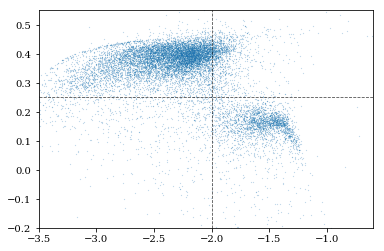

In [15]:
plt.scatter(feh, mgfe, s = 0.01)
plt.ylim(-0.2, 0.55)
plt.xlim(-3.5, -0.6)
plt.axvline(-2, ls = "--", color = 'black', lw = 0.8, alpha = 0.7)
plt.axhline(0.25, ls = "--", color = 'black', lw = 0.8, alpha = 0.7)



In [37]:
st375_d = 'galaxies/m10q/m10q_st375.p'
st600_d = 'galaxies/m10q/m10q_st600.p'
vr375_d = 'galaxies/m10q/m10q_vr375.p'
vr600_d = 'galaxies/m10q/m10q_vr600.p'

st375 = open(st375_d,'rb')
st600 = open(st600_d,'rb')
vr375 = open(vr375_d,'rb')
vr600 = open(vr600_d,'rb')

st_375 = pickle.load(st375, encoding = 'latin1')
st_600 = pickle.load(st600, encoding = 'latin1')
vr_375 = pickle.load(vr375, encoding = 'latin1')
vr_600 = pickle.load(vr600, encoding = 'latin1')

st = []
vr = []

for i in range(0, len(st_375)):
    st.append(st_375[i])
    vr.append(vr_375[i])
    
for i in range(0, len(st_600)):
    st.append(st_600[i])
    vr.append(vr_600[i])

In [38]:
timelist = np.arange(0, np.max(time), 0.01)
len(timelist)

1380

In [39]:
sfr = []
for i in range(0, len(time[35:600])-1):
    sfr.append((st[i+1] - st[i])/(1000000000)) #per Gyr

print(np.min(time[36]))

0.70584247


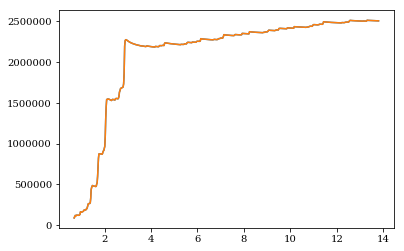

In [40]:
plt.plot(time[35:600], st)
plt.plot(time[35:600], vr)

2.86433573


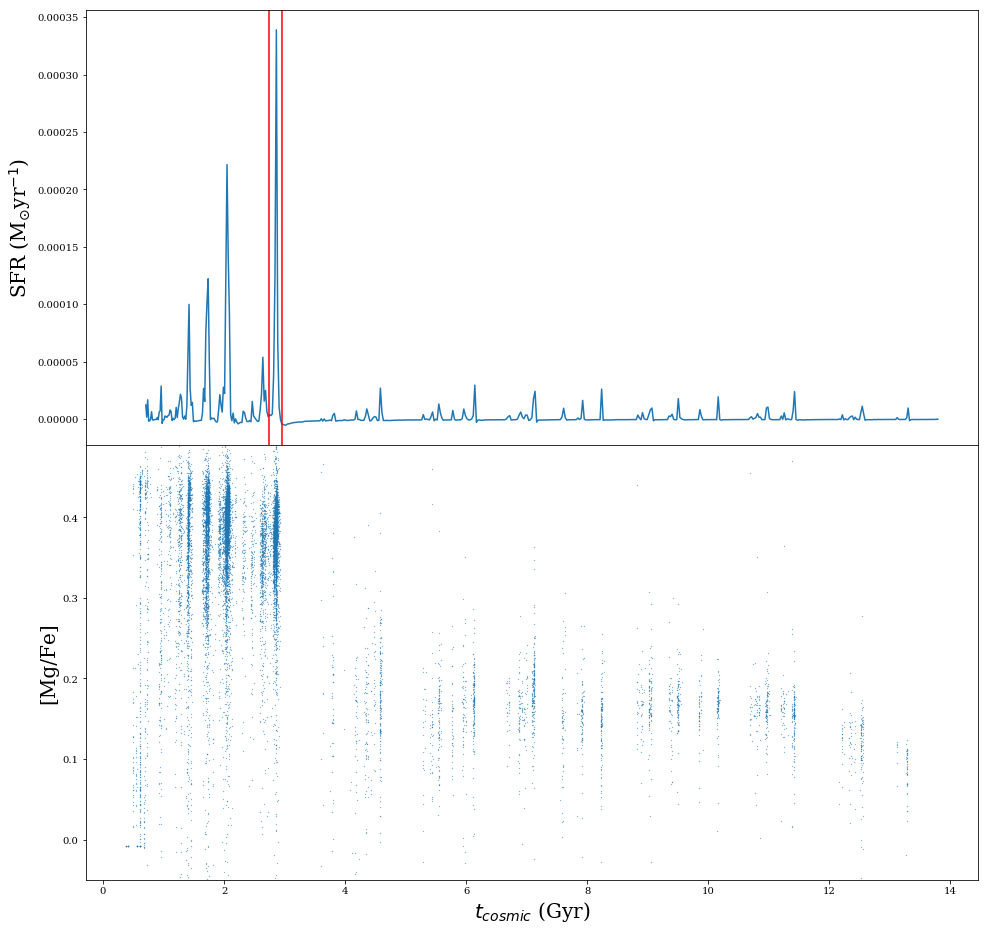

In [64]:
fig, (ax1, ax2) = matplotlib.pyplot.subplots(nrows=2, ncols=1, sharex = True, figsize = (16,16))

ax1.plot(time[36:600], sfr)
ax1.set_ylabel(r"SFR (M$_{\odot}$yr$^{-1}$)", size = 20)
ax1.axvline(2.75, color = 'r')
ax1.axvline(2.95, color = 'r')

print(time[150])

time_ind = np.where((time < 2.95) & (time > 2.75))

ax2.scatter(tform, mgfe, s = 0.05)
ax2.set_ylim(-.05, 0.49)
ax2.set_ylabel("[Mg/Fe]", size = 20)
ax2.set_xlabel(r"$t_{cosmic}$ (Gyr)", size = 20)

plt.subplots_adjust(wspace=.05, hspace=.0)

#plt.savefig("m10q_sfr.png", dpi = 150, bbox_inches = 'tight')


plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


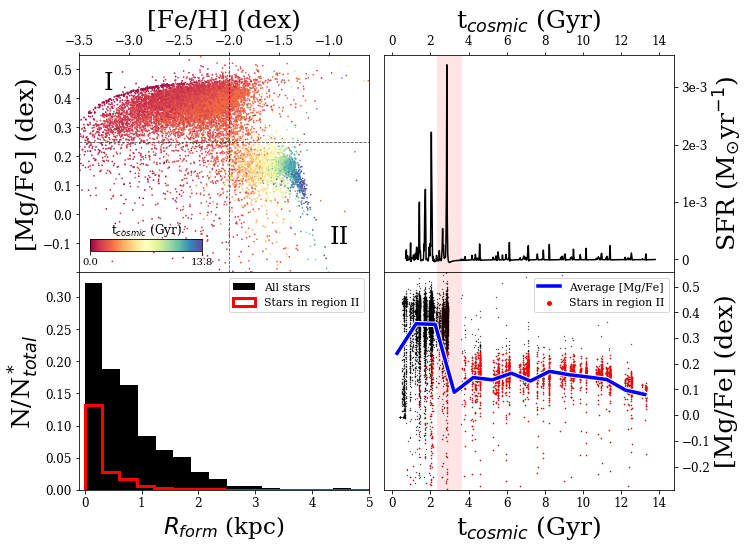

In [18]:
fig = plt.figure(figsize = (10.67,8), frameon = False)

tform = 13.7987-age

file_a = 'galaxies/m10q/main_mass'
main_m = open(file_a,'rb')
main_mass = pickle.load(main_m, encoding = 'latin1')

sec_ind = np.where( (mgfe <= 0.25) & (feh >= -2))

colors = ['black', 'red', 'blue', 'green']
ranges = [0,1,2,3]


ax1 = fig.add_subplot(2, 2, 1)

############# THE FOLLOWING CODE IS FOR GENERATING AN INSET COLORBAR ############

ind = np.where(Rform < 100)
counts1,xbins1,ybins1,image1 = plt.hist2d(feh[ind], mgfe[ind], bins = [100,100])

#mean age for bins of stars in mgfe vs feh space
mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(feh[ind], mgfe[ind], 
                                                                    age[ind], 'mean', bins= [100,100])

#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_age1)
im = ax1.imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = 'Spectral', aspect='auto', vmin=0, vmax=13.8)
ax1.clear()

cbar_ax = fig.add_axes([ 0.14, 0.54, 0.145, 0.02]) #left, bottom, width, height  # vertically oriented colorbar

cb = fig.colorbar(im, cax=cbar_ax, ticks = [0,13.8],  orientation = 'horizontal')
#cb.ax.yaxis.set_ticks_position("right")
#cb.ax.set_yticklabels(['0 Gyr', '13.8 Gyr'], fontweight = 15) # Used to make custom labels on the tick marks themselves
cb.ax.set_title(r"t$_{cosmic}$ (Gyr)")
#cb.ax.yaxis.set_label_position("left")

############# THE ABOVE CODE IS FOR GENERATING AN INSET COLORBAR ############

#ax1.scatter(feh,mgfe-0.0005, s = 0.5, alpha = 0.5, c = 'black')
ax1.scatter(feh,mgfe, s = 0.5, c = tform, cmap = "Spectral")
ax1.set_ylim(-0.2, 0.55)
ax1.axvline(-2, ls = "--", color = 'black', lw = 0.8, alpha = 0.7)
ax1.axhline(0.25, ls = "--", color = 'black', lw = 0.8, alpha = 0.7)

ax1.set_ylabel("[Mg/Fe] (dex)", size = 25)
ax1.set_xlabel("[Fe/H] (dex)", size = 25, labelpad = 7)
ax1.xaxis.set_label_position("top")
ax1.xaxis.tick_top()
ax1.set_xlim(-3.5,-0.6)

ax1.text(-3.25,0.43, "I", size = 24)
ax1.text(-1,-0.1, "II", size = 24)

xticks1 = ax1.xaxis.get_majorticklabels()
yticks1 = ax1.yaxis.get_majorticklabels()
plt.setp(yticks1[0], visible = False)


ax2 = fig.add_subplot(2, 2, 2)

ax2.axvline(3, lw = 25, color = 'r', alpha = 0.1)
ax2.ticklabel_format(useOffset=False, style = 'plain')
ax2.yaxis.set_ticks([0,1e-4,2e-4,3e-4])
ax2.yaxis.set_ticklabels(['0',r'1$\times 10^{-4}$',r'2$\times 10^{-4}$',r'3$\times 10^{-4}$'])
ax2.yaxis.set_ticklabels(['0','1e-3','2e-3','3e-3'])

ax2.plot(time[36:600], sfr, color = 'black')
#ell = matplotlib.patches.Ellipse(xy=[3, main_mass[160]-0.5e9], width=2.3, height= 0.17e10, angle = 0, color = 'red', 
#                                 fill = False, alpha = 0.5, lw = 2, label = "Mass accreted from second halo")
#ax2.add_artist(ell)

ax2.set_xlabel(r"t$_{cosmic}$ (Gyr)", size = 25, labelpad = 7)
ax2.xaxis.set_label_position("top")
ax2.xaxis.tick_top()
#ax2.legend(fontsize = 11)
ax2.set_ylabel(r"SFR (M$_{\odot}$yr$^{-1}$)", size = 25)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

xticks2 = ax2.xaxis.get_majorticklabels()
yticks2 = ax2.yaxis.get_majorticklabels()

weights1 = np.ones_like(Rform)/float(len(Rform))
weights2 = np.ones_like(Rform[sec_ind])/float(len(Rform))


ax3 = fig.add_subplot(2, 2, 3)
ax3.hist(Rform, bins = 470, color = 'black', label = "All stars", weights = weights1)
ax3.hist(Rform[sec_ind], bins = 47, color = 'red', histtype = 'step', weights = weights2,
         lw = 3, label = "Stars in region II")
ax3.legend(fontsize = 11)
ax3.set_ylabel(r"N/N$^*_{total}$", size = 25)
ax3.yaxis.set_label_position("left")
ax3.set_xlim(-0.1,5)

xticks3 = ax3.xaxis.get_majorticklabels()
yticks3 = ax3.yaxis.get_majorticklabels()

ax3.set_xlabel(r"$R_{form}$ (kpc)", size = 23)


tform = 13.7987 - age

#agers = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5]
agers = [0.25,1.25,2.25,3.25,4.25,5.25,6.25,7.25,8.25,9.25,10.25,11.25,12.25,13.25,14.25]

means = []

for i in range(0, len(agers)-1):
    ind = np.where((tform > agers[i]) & (tform < agers[i+1]))
    means.append(np.mean(mgfe[ind]))

means = np.array(means)
agers = np.array(agers)

ax4 = fig.add_subplot(2, 2, 4, sharex = ax2)
ax4.yaxis.tick_right()
#ax4.axvline(3, lw = 8, color = 'b', alpha = 0.5)
ax4.axvline(3, lw = 25, color = 'r', alpha = 0.1)

ax4.scatter(tform, mgfe, color = 'black', s = 0.1)
ax4.scatter(tform[sec_ind], mgfe[sec_ind], color = 'r', s = 0.2)
#ax4.axhline(np.mean(mgfe), color = 'green', label = "<[Mg/Fe]> = " + str(round(np.mean(mgfe),3)))
ax4.scatter(14,14, color = 'r', s = 15, label = "Stars in region II")
#ax4.plot(agers[0:14], means[0:14]-0.006, color = 'black', lw = 5, alpha = 0.5) 
ax4.plot(agers[0:14], means[0:14], color = 'white', lw = 5.5)    
ax4.plot(agers[0:14], means[0:14], color = 'b', lw = 3.5, label = "Average [Mg/Fe]")    


ax4.yaxis.set_label_position("right")
ax4.set_ylabel("[Mg/Fe] (dex)", size = 25)
ax4.set_ylim(-0.29, np.max(mgfe))

ax4.legend(fontsize = 11)

xticks4 = ax4.xaxis.get_majorticklabels()
yticks4 = ax4.yaxis.get_majorticklabels()
ax4.set_xlabel(r"t$_{cosmic}$ (Gyr)", size = 25)

plt.setp([xticks1,xticks2,xticks3,xticks4, yticks1, yticks2, yticks3, yticks4], size = 12)

plt.subplots_adjust(wspace=.05, hspace=.0)

#plt.figtext(0.505, .93, "m10q", ha = "center", size = 25) # MUCH better alternative to plt.text().

plt.savefig("m10q_master_may.png", dpi = 150)

plt.show()

Avg s[Fe/H]: 0.17268156424581005
Avg s[Mg/Fe]: 0.3975


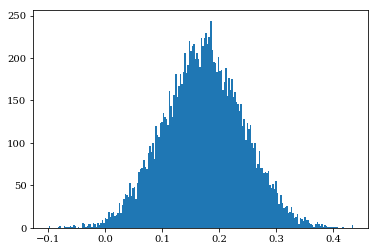

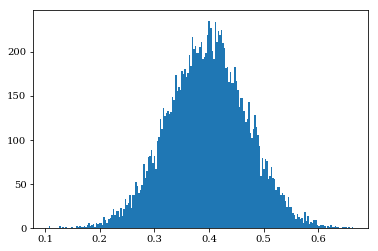

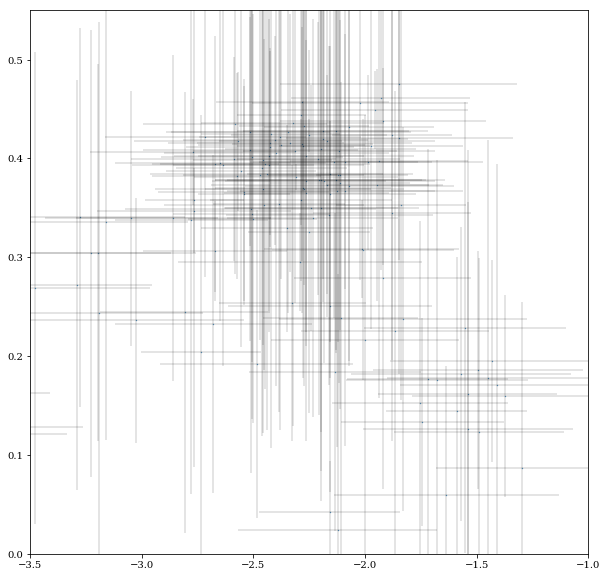

In [10]:
f_o, df_o, m_o, dm_o = np.loadtxt("Kirby_Tab3.txt", unpack = True, delimiter = ",")

sel_ind = np.where(m_o != 0)
feh_o = f_o[sel_ind]
dfeh_o = df_o[sel_ind]
mgfe_o = m_o[sel_ind]
dmgfe_o = dm_o[sel_ind]

avg_f = np.average(df_o)
s_f = np.std(df_o)
avg_m = np.average(dmgfe_o)
s_m = np.std(dmgfe_o)

print("Avg s[Fe/H]: " + str(avg_f))
print("Avg s[Mg/Fe]: " + str(avg_m))

feh_err = np.random.normal(avg_f, s_f, len(feh))
mgfe_err = np.random.normal(avg_m, s_m, len(mgfe))
plt.hist(feh_err, bins = 200)
plt.show()

plt.hist(mgfe_err, bins = 200)
plt.show()

np.random.choice(feh_err)

start_range = int(len(mgfe)/2 )
end_range = start_range + 150

s_r = start_range
e_r = end_range

plt.figure(figsize = (10,10))
plt.scatter(feh[s_r:e_r], mgfe[s_r:e_r], s = 0.1)
plt.errorbar(feh[s_r:e_r], mgfe[s_r:e_r], yerr = feh_err[s_r:e_r], xerr = mgfe_err[s_r:e_r], ls = 'none',
             lw = 0.21, color = 'black')
plt.xlim(-3.5,-1)
plt.ylim(0,0.55)
plt.show()

# FIGURE 2 BELOW THIS POINT

## DARK MATTER VERSION

In [ ]:
sec_ind = np.where( (mgfe <= 0.25) * (feh >= -2))

file_a = 'galaxies/m10q/main_mass'
main_m = open(file_a,'rb')
main_mass = pickle.load(main_m, encoding = 'latin1')

fig = plt.figure(figsize = (10.67,8), frameon = False)

ax1 = fig.add_subplot(321)
ax1.plot(time[60:600], main_mass, color = 'black', label = "Total Mass of Main Halo")
#ax1.set_ylim(2.5e9,np.max(main_mass)+5e8)
ax1.legend()
ax1.set_ylabel(r"M$_\odot$", size = 25)

ax2 = fig.add_subplot(323, sharex = ax1)
ax2.scatter(13.7-age, mgfe, s = 0.1, color = 'black')
ax2.scatter(13.7-age[sec_ind], mgfe[sec_ind], s = 0.1, color = 'red', label = "Stars in secondary track")

ax2.set_ylabel("[Mg/Fe]", size = 25)
ax2.set_ylim(-0.5,0.58)

ax3 = fig.add_subplot(325, sharex = ax1)
ax3.hist(13.79874688 - age, bins = 50, color = 'black')
ax3.hist(13.79874688 - age[sec_ind], bins = 53, histtype='step', lw = 3, color = 'red', label = 'Stars in secondary track')
ax3.legend()
ax3.set_xlabel("Time (Gyr)", size = 25)
ax3.set_ylabel(r"$n_{stars}$", size = 25)

ax4 = fig.add_subplot(222)
ax4.set_xticks([]) 
ax4.set_yticks([]) 
    
    
# THIS IS WHERE IT GETS UGLY - MAKING THE DENSITY PLOTS FOR GAS IN m10q

file_x1 = 'galaxies/m10q/x143d'
x143 = open(file_x1,'rb')
file_y1 = 'galaxies/m10q/y143d'
y143 = open(file_y1,'rb')
file_m1 = 'galaxies/m10q/m143d'
m143 = open(file_m1,'rb')

x_143 = pickle.load(x143, encoding = 'latin1')
y_143 = pickle.load(y143, encoding = 'latin1')
m_143 = pickle.load(m143, encoding = 'latin1')

file_x2 = 'galaxies/m10q/x146d'
x146 = open(file_x2,'rb')
file_y2 = 'galaxies/m10q/y146d'
y146 = open(file_y2,'rb')
file_m2 = 'galaxies/m10q/m146d'
m146 = open(file_m2,'rb')

x_146 = pickle.load(x146, encoding = 'latin1')
y_146 = pickle.load(y146, encoding = 'latin1')
m_146 = pickle.load(m146, encoding = 'latin1')

#ax4.set_xlabel('x (kpc)', size = 25)
#ax4.set_ylabel('y (kpc)', size = 25)
#ax4.set_xlim(-5, 5)
#ax4.set_ylim(-5, 5)
#ax4.set_title('m10q (z=0)', size = 25)
#ax4.get_yaxis()

bin_edge = 10 #how far out in the disk
width = .075 #sam: 100-200 pc for pretty pics, 750 for analysis
ksbin = np.arange(-1.*(bin_edge)+width/2.,(bin_edge)+width/2.,width)  #i am passing the positions of the bins into hist2d

print(len(m_143))
print(len(x_143))

vmn = 6e6
vmx = 1e8
# stretch factor for imshow
s_f = 1.7

#bin up the data
den, xh, yh = np.histogram2d(y_143, x_143, weights=m_143, bins=[ksbin/s_f, ksbin]) #x & y have to be inverted in histogram!

im = ax4.imshow(den/(width**2), interpolation='nearest',extent=(-1.*s_f*bin_edge,bin_edge,-1.*bin_edge,bin_edge), 
               origin='lower', vmin=vmn, vmax=vmx, norm=matplotlib.colors.LogNorm(), cmap='bone')
ax4.arrow(4.4,5,0,-5, lw = 1, color = 'w', head_width = 1)
ax4.plot([-15,-6.5],[-8,-8], lw = 3, color = 'w')
ax4.text(-15,-7.5, "5 kpc", color = 'w', size = 20)
ax4.set_title("Density plot of Dark Matter")
ax4.text(-15,7.5, "t = 2.32 Gyr", color = 'w', size = 20)

#Colorbar below
cbar_ax = fig.add_axes([0.91, 0.124, 0.02, 0.75]) #left, bottom, width, height

cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(r'$\Sigma_{*}$ (M$_{\odot}$/pc$^2$)', size =20)

#outfile = ‘/Users/sloebman/Dropbox/RESEARCH/ANDREW/clusters/figures/m12m.youngstars.x.y.eps’
#plt.savefig("m10q_density_at_present.png", bbox_inches = 'tight', dpi = 150)



ax5 = fig.add_subplot(224)
den, xh, yh = np.histogram2d(y_146, x_146, weights=m_146, bins=[ksbin/s_f, ksbin]) #x & y have to be inverted in histogram!

im = ax5.imshow(den/(width**2), interpolation='nearest',extent=(-1.*s_f*bin_edge,bin_edge,-1.*bin_edge,bin_edge), 
               origin='lower', vmin=vmn, vmax=vmx, norm=matplotlib.colors.LogNorm(), cmap='bone')

ax5.set_xticks([]) 
ax5.set_yticks([]) 
ax5.arrow(1,5,0,-5, lw = 1, color = 'w', head_width = 1)
# Dashed lines
#ax5.plot([1.1,4.2],[-3.5,-3.75], color = 'w', ls = ':')
# Bar/5 kpc limit
ax5.plot([-15,-6.5],[-8,-8], lw = 3, color = 'w')
ax5.text(-15,-7.5, "5 kpc", color = 'w', size = 20)
ax5.text(-15,7.5, "t = 2.39 Gyr", color = 'w', size = 20)


plt.subplots_adjust(wspace=.03, hspace=.0)

axs = [ax1,ax2,ax3,ax4,ax5]
xticks = []
for i in range(0,5):
    xticks.append(axs[i].xaxis.get_majorticklabels())
    yticks.append(axs[i].yaxis.get_majorticklabels())
plt.savefig("m10q_progress_dark.png", dpi = 150)
plt.show()



In [ ]:
plt.figure(figsize = (8,8))
plt.hist2d(x_143,y_143, bins = 50, range = [[-5,5],[-5,5]], cmap = "bone")
plt.show()

## GAS VERSION

In [ ]:
sec_ind = np.where( (mgfe <= 0.25) * (feh >= -2))

file_a = 'galaxies/m10q/main_mass'
main_m = open(file_a,'rb')
main_mass = pickle.load(main_m, encoding = 'latin1')

fig = plt.figure(figsize = (10.67,8), frameon = False)

ax1 = fig.add_subplot(321)
ax1.plot(time[60:600], main_mass, color = 'black', label = "Total Mass of Main Halo")
#ax1.set_ylim(2.5e9,np.max(main_mass)+5e8)
ax1.legend()
ax1.set_ylabel(r"M$_\odot$", size = 25)

ax2 = fig.add_subplot(323, sharex = ax1)
ax2.scatter(13.7-age, mgfe, s = 0.1, color = 'black')
ax2.scatter(13.7-age[sec_ind], mgfe[sec_ind], s = 0.1, color = 'red', label = "Stars in secondary track")

ax2.set_ylabel("[Mg/Fe]", size = 25)
ax2.set_ylim(-0.5,0.58)

ax3 = fig.add_subplot(325, sharex = ax1)
ax3.hist(13.79874688 - age, bins = 50, color = 'black')
ax3.hist(13.79874688 - age[sec_ind], bins = 53, histtype='step', lw = 3, color = 'red', label = 'Stars in secondary track')
ax3.axvline(2.4)
ax3.legend()
ax3.set_xlabel("Time (Gyr)", size = 25)
ax3.set_ylabel(r"$n_{stars}$", size = 25)

ax4 = fig.add_subplot(222)
ax4.set_xticks([]) 
ax4.set_yticks([]) 
    
    
# THIS IS WHERE IT GETS UGLY - MAKING THE DENSITY PLOTS FOR GAS IN m10q

file_x1 = 'galaxies/m10q/x143'
x143 = open(file_x1,'rb')
file_y1 = 'galaxies/m10q/y143'
y143 = open(file_y1,'rb')
file_m1 = 'galaxies/m10q/m143'
m143 = open(file_m1,'rb')

x_143 = pickle.load(x143, encoding = 'latin1')
y_143 = pickle.load(y143, encoding = 'latin1')
m_143 = pickle.load(m143, encoding = 'latin1')

file_x2 = 'galaxies/m10q/x146'
x146 = open(file_x2,'rb')
file_y2 = 'galaxies/m10q/y146'
y146 = open(file_y2,'rb')
file_m2 = 'galaxies/m10q/m146'
m146 = open(file_m2,'rb')

x_146 = pickle.load(x146, encoding = 'latin1')
y_146 = pickle.load(y146, encoding = 'latin1')
m_146 = pickle.load(m146, encoding = 'latin1')

#ax4.set_xlabel('x (kpc)', size = 25)
#ax4.set_ylabel('y (kpc)', size = 25)
#ax4.set_xlim(-5, 5)
#ax4.set_ylim(-5, 5)
#ax4.set_title('m10q (z=0)', size = 25)
#ax4.get_yaxis()

bin_edge = 10 #how far out in the disk
width = .2 #sam: 100-200 pc for pretty pics, 750 for analysis
ksbin = np.arange(-1.*(bin_edge)+width/2.,(bin_edge)+width/2.,width)  #i am passing the positions of the bins into hist2d

print(len(m_143))
print(len(x_143))

vmn = 2e5
vmx = 1e7
# stretch factor for imshow
s_f = 1.7

r_143 = np.sqrt(y_143**2 + x_143**2)
r_146 = np.sqrt(y_146**2 + x_146**2)

ind143 = np.where(r_143 >= 3)
ind146 = np.where(r_146 >= 3)

#bin up the data
den, xh, yh = np.histogram2d(y_143, x_143, weights=m_143, bins=[ksbin/s_f, ksbin]) #x & y have to be inverted in histogram!

im = ax4.imshow(den/(width**2), interpolation='nearest',extent=(-1.*s_f*bin_edge,bin_edge,-1.*bin_edge,bin_edge), 
               origin='lower', vmin=vmn, vmax=vmx, norm=matplotlib.colors.LogNorm(), cmap='magma')

ell = matplotlib.patches.Ellipse(xy=[4.4,-3], width=3.3, height=3.3, angle = 0, color = 'w', ls = ':', fill = False,
                                alpha = 0.5)
ax4.add_artist(ell)

ax4.arrow(4.4,5,0,-4.5, lw = 1, color = 'w', head_width = 1)
ax4.plot([-15,-6.5],[-8,-8], lw = 3, color = 'w')
ax4.text(-15,-7.5, "5 kpc", color = 'w', size = 20)
ax4.set_title("Density plot of Gas")
ax4.text(-15,7.5, "t = 2.32 Gyr", color = 'w', size = 20)

#Colorbar below
cbar_ax = fig.add_axes([0.91, 0.124, 0.02, 0.75]) #left, bottom, width, height

cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(r'$\Sigma_{*}$ (M$_{\odot}$/pc$^2$)', size =20)

ax5 = fig.add_subplot(224)
den, xh, yh = np.histogram2d(y_146, x_146, weights=m_146, bins=[ksbin/s_f, ksbin]) #x & y have to be inverted in histogram!

im = ax5.imshow(den/(width**2), interpolation='nearest',extent=(-1.*s_f*bin_edge,bin_edge,-1.*bin_edge,bin_edge), 
               origin='lower', vmin=vmn, vmax=vmx, norm=matplotlib.colors.LogNorm(), cmap='magma')

ax5.set_xticks([]) 
ax5.set_yticks([]) 
ax5.arrow(1,5,0,-5, lw = 1, color = 'w', head_width = 1)
# Dashed lines
#ax5.plot([1.1,4.2],[-3.5,-3.75], color = 'w', ls = ':')
# Bar/5 kpc limit
ax5.plot([-15,-6.5],[-8,-8], lw = 3, color = 'w')

ell2 = matplotlib.patches.Ellipse(xy=[1.1,-3.5], width=3.3, height=3.3, angle = 0, color = 'w', ls = ':', fill = False,
                                 alpha = 0.5)
ax5.add_artist(ell2)


ax5.text(-15,-7.5, "5 kpc", color = 'w', size = 20)
ax5.text(-15,7.5, "t = 2.39 Gyr", color = 'w', size = 20)


plt.subplots_adjust(wspace=.03, hspace=.0)

plt.savefig("m10q_progress_gas.png", dpi = 150)
plt.show()



## BOTH

### LOADING DATA

In [ ]:
file_x1 = 'galaxies/m10q/x143'
x143 = open(file_x1,'rb')
file_y1 = 'galaxies/m10q/y143'
y143 = open(file_y1,'rb')
file_m1 = 'galaxies/m10q/m143'
m143 = open(file_m1,'rb')

x_143 = pickle.load(x143, encoding = 'latin1')
y_143 = pickle.load(y143, encoding = 'latin1')
m_143 = pickle.load(m143, encoding = 'latin1')

file_x2 = 'galaxies/m10q/x146'
x146 = open(file_x2,'rb')
file_y2 = 'galaxies/m10q/y146'
y146 = open(file_y2,'rb')
file_m2 = 'galaxies/m10q/m146'
m146 = open(file_m2,'rb')

x_146 = pickle.load(x146, encoding = 'latin1')
y_146 = pickle.load(y146, encoding = 'latin1')
m_146 = pickle.load(m146, encoding = 'latin1')
###########################################################################################################################
file_x1 = 'galaxies/m10q/x143d'
x143 = open(file_x1,'rb')
file_y1 = 'galaxies/m10q/y143d'
y143 = open(file_y1,'rb')
file_m1 = 'galaxies/m10q/m143d'
m143 = open(file_m1,'rb')

x_143d = pickle.load(x143, encoding = 'latin1')
y_143d = pickle.load(y143, encoding = 'latin1')
m_143d = pickle.load(m143, encoding = 'latin1')

file_x2 = 'galaxies/m10q/x146d'
x146 = open(file_x2,'rb')
file_y2 = 'galaxies/m10q/y146d'
y146 = open(file_y2,'rb')
file_m2 = 'galaxies/m10q/m146d'
m146 = open(file_m2,'rb')

x_146d = pickle.load(x146, encoding = 'latin1')
y_146d = pickle.load(y146, encoding = 'latin1')
m_146d = pickle.load(m146, encoding = 'latin1')

In [ ]:
sec_ind = np.where( (mgfe <= 0.25) * (feh >= -2))

fig = plt.figure(figsize = (18,8), frameon = False)

bin_edge = 10 #how far out in the disk
width = .2 #sam: 100-200 pc for pretty pics, 750 for analysis
ksbin = np.arange(-1.*(bin_edge)+width/2.,(bin_edge)+width/2.,width)  #i am passing the positions of the bins into hist2d

print(len(m_143))
print(len(x_143))

vmn = 2e5
vmx = 1e7
# stretch factor for imshow
s_f = 1.6

r_143 = np.sqrt(y_143**2 + x_143**2)
r_146 = np.sqrt(y_146**2 + x_146**2)

ind143 = np.where(r_143 >= 3)
ind146 = np.where(r_146 >= 3)

ax4 = fig.add_subplot(221)
ax4.set_xticks([]) 
ax4.set_yticks([]) 

#bin up the data
den, xh, yh = np.histogram2d(y_143, x_143, weights=m_143, bins=[ksbin/s_f, ksbin]) #x & y have to be inverted in histogram!

im = ax4.imshow(den/(width**2), interpolation='nearest',extent=(-1.*s_f*bin_edge,bin_edge,-1.*bin_edge,bin_edge), 
               origin='lower', vmin=vmn, vmax=vmx, norm=matplotlib.colors.LogNorm(), cmap='magma')

ell = matplotlib.patches.Ellipse(xy=[4.4,-3], width=3.3, height=3.3, angle = 0, color = 'w', lw = 3, ls = ':', fill = False,
                                alpha = 0.8)
ax4.add_artist(ell)

ax4.arrow(4.4,5,0,-4.5, lw = 1, color = 'w', head_width = 1)
ax4.plot([-14.5,-6.5],[-8,-8], lw = 3, color = 'w')
ax4.text(-14.5,-7.5, "5 kpc", color = 'w', size = 20)
ax4.set_title("Density plot of Gas")
ax4.text(-14.5,7.5, "t = 2.32 Gyr", color = 'w', size = 20)

#Colorbar below
cbar_ax = fig.add_axes([0.488, 0.124, 0.02, 0.755]) #left, bottom, width, height

cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=12) 

ax3 = fig.add_subplot(223)
den, xh, yh = np.histogram2d(y_146, x_146, weights=m_146, bins=[ksbin/s_f, ksbin]) #x & y have to be inverted in histogram!

im = ax3.imshow(den/(width**2), interpolation='nearest',extent=(-1.*s_f*bin_edge,bin_edge,-1.*bin_edge,bin_edge), 
               origin='lower', vmin=vmn, vmax=vmx, norm=matplotlib.colors.LogNorm(), cmap='magma')

ax3.set_xticks([]) 
ax3.set_yticks([]) 
ax3.arrow(1,5,0,-5, lw = 1, color = 'w', head_width = 1)
# Dashed lines
#ax5.plot([1.1,4.2],[-3.5,-3.75], color = 'w', ls = ':')
# Bar/5 kpc limit
ax3.plot([-14.5,-6.5],[-8,-8], lw = 3, color = 'w')

ell2 = matplotlib.patches.Ellipse(xy=[1.1,-3.5], width=3.3, height=3.3, angle = 0, color = 'w', lw = 3,ls = ':', fill = False,
                                 alpha = 0.8)
ax3.add_artist(ell2)


ax3.text(-14.5,-7.5, "5 kpc", color = 'w', size = 20)
ax3.text(-14.5,7.5, "t = 2.39 Gyr", color = 'w', size = 20)


#### GAS  MATTER ABOVE ######
#### DARK MATTER BELOW ######

ax1 = fig.add_subplot(222)
ax1.set_xticks([]) 
ax1.set_yticks([]) 

bin_edge = 10 #how far out in the disk
width = .075 #sam: 100-200 pc for pretty pics, 750 for analysis
ksbin = np.arange(-1.*(bin_edge)+width/2.,(bin_edge)+width/2.,width)  #i am passing the positions of the bins into hist2d

vmn = 6e6
vmx = 1e8
# stretch factor for imshow

#bin up the data
den, xh, yh = np.histogram2d(y_143d, x_143d, weights=m_143d, bins=[ksbin/s_f, ksbin]) #x & y have to be inverted in histogram!

im = ax1.imshow(den/(width**2), interpolation='nearest',extent=(-1.*s_f*bin_edge,bin_edge,-1.*bin_edge,bin_edge), 
               origin='lower', vmin=vmn, vmax=vmx, norm=matplotlib.colors.LogNorm(), cmap='bone')
ax1.arrow(4.4,5,0,-5, lw = 1, color = 'w', head_width = 1)
ax1.plot([-14.5,-6.5],[-8,-8], lw = 3, color = 'w')
ax1.text(-14.5,-7.5, "5 kpc", color = 'w', size = 20)
ax1.set_title("Density plot of Dark Matter")
ax1.text(-14.5,7.5, "t = 2.32 Gyr", color = 'w', size = 20)

#Colorbar below
cbar_ax = fig.add_axes([0.875, 0.124, 0.02, 0.755]) #left, bottom, width, height

cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(r'$\Sigma$ (M$_{\odot}$/pc$^2$)', size =20)
cb.ax.tick_params(labelsize=12) 

#outfile = ‘/Users/sloebman/Dropbox/RESEARCH/ANDREW/clusters/figures/m12m.youngstars.x.y.eps’
#plt.savefig("m10q_density_at_present.png", bbox_inches = 'tight', dpi = 150)

ax2 = fig.add_subplot(224)
den, xh, yh = np.histogram2d(y_146d, x_146d, weights=m_146d, bins=[ksbin/s_f, ksbin]) #x & y have to be inverted in histogram!

im = ax2.imshow(den/(width**2), interpolation='nearest',extent=(-1.*s_f*bin_edge,bin_edge,-1.*bin_edge,bin_edge), 
               origin='lower', vmin=vmn, vmax=vmx, norm=matplotlib.colors.LogNorm(), cmap='bone')

ax2.set_xticks([]) 
ax2.set_yticks([]) 
ax2.arrow(1,5,0,-5, lw = 1, color = 'w', head_width = 1)
# Dashed lines
#ax5.plot([1.1,4.2],[-3.5,-3.75], color = 'w', ls = ':')
# Bar/5 kpc limit
ax2.plot([-14.5,-6.5],[-8,-8], lw = 3, color = 'w')
ax2.text(-14.5,-7.5, "5 kpc", color = 'w', size = 20)
ax2.text(-14.5,7.5, "t = 2.39 Gyr", color = 'w', size = 20)

plt.subplots_adjust(wspace=.0, hspace=.0)


elld1 = matplotlib.patches.Ellipse(xy=[1.1,-3.5], width=3.3, height=3.3, angle = 0, color = 'w', lw = 3,ls = ':', fill = False,
                                 alpha = 0.8)
ax2.add_artist(elld1)

elld2 = matplotlib.patches.Ellipse(xy=[4.4,-3], width=3.3, height=3.3, angle = 0, color = 'w', lw = 3, ls = ':', fill = False,
                                alpha = 0.8)
ax1.add_artist(elld2)


plt.savefig("m10q_progress_both.png", dpi = 150, bbox_inches = 'tight')
plt.show()

